# Librerías

In [1]:
import os

# Librerias base para el analisis y manejo de datos
import numpy as np
import pandas as pd

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Librerias con los modelos principales
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids 

# Libnreria para medir los resultados de los modelos
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score

# Libreria para graficar
import matplotlib.pyplot as plt

# Estandarizar la data
from sklearn.preprocessing import StandardScaler

# Reducir la dimensionalidad para graficas
from sklearn.manifold import MDS

# metodo para recrear un iterador infinito
from itertools import cycle

# Funciones

In [2]:
def convertir_col_numericas(df, lista_columnas):

    for columna in lista_columnas:

        df[columna] = df[columna].str.replace(',00', '', regex=False)
        df[columna] = df[columna].str.replace('.', '', regex=False)
        df[columna] = df[columna].str.replace(',', '.', regex=False).astype(float)

    return df

def porcentaje_participacion(df, lista_col, col_total):

    for col in lista_col:
        
        df[f'Porc_part_{col}'] = df[col] / df[col_total]

    return df


def crear_grafico_dispersion(modelo_fit, df, y):
    colors = plt.cm.tab20.colors + plt.cm.tab20b.colors
    color_cycle = cycle(colors)
    mds = MDS(n_components=2, dissimilarity = 'euclidean', random_state=123)
    df_transformado = mds.fit_transform(df)

    unique_labels = np.unique(modelo_fit.labels_)

    plt.figure(figsize=(10, 7))
    
    for idx, label in enumerate(unique_labels):
        color = next(color_cycle)  # Obtener el siguiente color del ciclo
        plt.scatter(df_transformado[modelo_fit.labels_ == label, 0], 
                    df_transformado[modelo_fit.labels_ == label, 1], 
                    label=f'Cluster {label}',
                    color=color)
    # Agregar las etiquetas de cada punto
    for i in range(df_transformado.shape[0]):
        plt.text(df_transformado[i, 0], 
                 df_transformado[i, 1], 
                 y.iloc[i, 0],  
                 fontsize=9, 
                 ha='right', 
                 color='black')

    plt.title('MDS Plot of Data with Labels')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

# Preparación bases de datos

## Base municipios

In [3]:
# Base Municipios
df_base = pd.read_excel("../Data/DIVIPOLA_Municipios.xlsx")

#
display(df_base.shape)
df_base.head()

(1122, 5)

,CodigoD,Departamento,CodigoM,Municipio,tipo
0,5,ANTIOQUIA,5001,MEDELLÍN,Municipio
1,5,ANTIOQUIA,5002,ABEJORRAL,Municipio
2,5,ANTIOQUIA,5004,ABRIAQUÍ,Municipio
3,5,ANTIOQUIA,5021,ALEJANDRÍA,Municipio
4,5,ANTIOQUIA,5030,AMAGÁ,Municipio


In [4]:
df_base[df_base['CodigoM'] == 5001]

,CodigoD,Departamento,CodigoM,Municipio,tipo
0,5,ANTIOQUIA,5001,MEDELLÍN,Municipio


## Finanzas

In [5]:
# Fiananzas
df_finanzas = pd.read_csv("../Data/archivos_csv/Fiananzascompilado.txt", sep="|", encoding="utf-8")

# Se toma del dataset el valor del presupuesto del SGP asignado a las entidades territoriales para el último año
df_finanzas = df_finanzas[(df_finanzas['Subcategoría']== 'SGP - Distribución asignaciones SGP por sectores') & (df_finanzas['Año']== 2023)]

# Previsualizacion de los datos
display(df_finanzas.shape)
df_finanzas.head(5)

(11020, 13)

,Código Departamento,Departamento,Código Entidad,Entidad,Dimensión,Subcategoría,Indicador,Dato Numérico,Dato Cualitativo,Año,Mes,Fuente,Unidad de Medida
873458,97,Vaupés,97666,Taraira,Finanzas públicas,SGP - Distribución asignaciones SGP por sectores,Educación,"51.090.331,00",NaN,2023,12,DNP - SICODIS SGP,Pesos corrientes
873459,97,Vaupés,97001,Mitú,Finanzas públicas,SGP - Distribución asignaciones SGP por sectores,Educación,"1.681.219.455,00",NaN,2023,12,DNP - SICODIS SGP,Pesos corrientes
873460,97,Vaupés,97161,Carurú,Finanzas públicas,SGP - Distribución asignaciones SGP por sectores,Educación,"47.574.440,00",NaN,2023,12,DNP - SICODIS SGP,Pesos corrientes
873461,95,Guaviare,95025,El Retorno,Finanzas públicas,SGP - Distribución asignaciones SGP por sectores,Educación,"503.328.677,00",NaN,2023,12,DNP - SICODIS SGP,Pesos corrientes
873462,95,Guaviare,95015,Calamar,Finanzas públicas,SGP - Distribución asignaciones SGP por sectores,Educación,"307.343.477,00",NaN,2023,12,DNP - SICODIS SGP,Pesos corrientes


In [6]:
# Identificamos los indicadores que se tienen por municipio
df_finanzas['Indicador'].unique()

array(['Educación', 'Salud', 'Agua potable', 'Propósito general',
       'Alimentación escolar', 'Ribereños', 'Resguardos indígenas',
       'Primera infancia', 'Fonpet', 'Total SGP'], dtype=object)

In [7]:
# Filtramos aquellos datos que no son de interés para el estudio
lista_var_eliminar = ['Salud', 'Agua potable', 'Alimentación escolar', 'Primera infancia', 'Ribereños', 'Resguardos indígenas', 'Fonpet']
df_finanzas = df_finanzas[~df_finanzas['Indicador'].isin(lista_var_eliminar)]

In [8]:
# dejar datos por municipio / son 23 años
df_finanzas1 = df_finanzas.pivot(
    index=['Código Entidad', 'Entidad'],
    columns='Indicador',
    values='Dato Numérico'
).reset_index()

In [9]:
df_finanzas1['Educación'].dtype

dtype('O')

In [10]:
# Estandarizar columnas numericas
df_finanzas1 = convertir_col_numericas(df_finanzas1, ['Educación', 'Propósito general', 'Total SGP'])


In [11]:
# Porcentaje participacion
df_finanzas1 = porcentaje_participacion(df_finanzas1, ['Educación', 'Propósito general'], 'Total SGP')

In [12]:
df_finanzas1.head(5)

Indicador,Código Entidad,Entidad,Educación,Propósito general,Total SGP,Porc_part_Educación,Porc_part_Propósito general
0,5001,Medellín,758974110062.00,103927867431.00,1251754434226.00,0.61,0.08
1,5002,Abejorral,404412508.00,4205632172.00,11963494363.00,0.03,0.35
2,5004,Abriaquí,50581324.00,1680505703.00,3145853128.00,0.02,0.53
3,5021,Alejandría,90393124.00,2169520879.00,4576185109.00,0.02,0.47
4,5030,Amagá,514801342.00,2985753107.00,10049664896.00,0.05,0.30


In [13]:
# Seleccion final de variables
edu_seleccionadas = ['Código Entidad', 'Entidad', 'Porc_part_Educación', 'Porc_part_Propósito general']

df_finanzas_final = df_finanzas1[edu_seleccionadas]

In [14]:
df_finanzas_final.head(3)

Indicador,Código Entidad,Entidad,Porc_part_Educación,Porc_part_Propósito general
0,5001,Medellín,0.61,0.08
1,5002,Abejorral,0.03,0.35
2,5004,Abriaquí,0.02,0.53


In [15]:
df_finanzas_final.groupby('Código Entidad').size().reset_index(name='cantidad').sort_values(by='cantidad', ascending=False).head(2)


,Código Entidad,cantidad
1101,99773,1
0,5001,1


## Economia

In [16]:
# Economia
df_economia = pd.read_csv("../Data/archivos_csv/Economia.csv", sep=";", encoding="ISO-8859-1", low_memory=False)
df_economia = df_economia[(df_economia['Año']==2023) & (df_economia['Subcategoría']== 'PIB')]
df_economia['Código Departamento'] = df_economia['Código Departamento'].astype(int)

# 
display(df_economia.shape)
df_economia.head()

(527, 13)

,Código Departamento,Departamento,Código Entidad,Entidad,Dimensión,Subcategoría,Indicador,Dato Numérico,Dato Cualitativo,Año,Mes,Fuente,Unidad de Medida
350587,1,Colombia,1001.00,Colombia,Economía,PIB,PIB,"1.572.458,38",Dato preliminar,2023.00,12.00,DANE,Miles de millones de pesos corrientes
350588,8,Atlántico,8000.00,Atlántico,Economía,PIB,PIB,"70.200,98",Dato preliminar,2023.00,12.00,DANE,Miles de millones de pesos corrientes
350589,5,Antioquia,5000.00,Antioquia,Economía,PIB,PIB,"231.052,39",Dato preliminar,2023.00,12.00,DANE,Miles de millones de pesos corrientes
350590,13,Bolívar,13000.00,Bolívar,Economía,PIB,PIB,"56.626,16",Dato preliminar,2023.00,12.00,DANE,Miles de millones de pesos corrientes
350591,17,Caldas,17000.00,Caldas,Economía,PIB,PIB,"25.947,82",Dato preliminar,2023.00,12.00,DANE,Miles de millones de pesos corrientes


In [17]:
# Identificamos los indicadores presentes en el dataset
df_economia['Indicador'].unique()

array(['PIB', 'PIB per cápita',
       'Participación del PIB departamental en el nacional',
       'PIB por actividades económicas - Agricultura, ganadería, caza, silvicultura y pesca (Agricultura, ganadería, caza, silvicultura y pesca)',
       'PIB por actividades económicas - Explotación de minas y canteras (Explotación de minas y canteras)',
       'PIB por actividades económicas - Industrias manufactureras (Industrias manufactureras)',
       'PIB por actividades económicas - Electricidad, gas, vapor y saneamiento ambiental (Suministro de electricidad, gas, vapor y aire acondicionado; distribución de agua; evacuación y tratamiento de aguas residuales, gestión de desechos y actividades de saneamiento ambiental)',
       'PIB por actividades económicas - Construcción (Construcción)',
       'PIB por actividades económicas - Comercio (Comercio al por mayor y al por menor; reparación de vehículos automotores y motocicletas; transporte y almacenamiento; alojamiento y servicios de comi

In [18]:
# Escogemos los indicadores relevantes para el estudio

llaves = [
    'PIB per cápita', 'PIB',
    'PIB por actividades económicas - Información y comunicaciones (Información y comunicaciones)',
    'PIB por actividades económicas - Actividades financieras (Actividades financieras y de seguros)',
    'PIB por actividades económicas - Actividades profesionales (Actividades profesionales, científicas y técnicas; actividades de servicios administrativos y de apoyo)'
]
 

lista_economia1 = ['PIB',
                  'PIB_per_capita',
                  'PIB_info_comunicaciones',
                  'PIB_act_financieras',
                  'PIB_act_prof'
                 ]

# Filtramos aquellos datos que no son de interés para el estudio
df_economia = df_economia[df_economia['Indicador'].isin(llaves)]

In [19]:
# dejar datos por municipio
df_economia1 = df_economia.pivot(
    index=['Código Departamento', 'Departamento'],
    columns='Indicador',
    values='Dato Numérico'
).reset_index()

In [20]:
df_economia1 = df_economia1.rename(columns={
    'PIB per cápita': 'PIB_per_capita',
    'PIB por actividades económicas - Información y comunicaciones (Información y comunicaciones)': 'PIB_info_comunicaciones',
    'PIB por actividades económicas - Actividades financieras (Actividades financieras y de seguros)': 'PIB_act_financieras',
    'PIB por actividades económicas - Actividades profesionales (Actividades profesionales, científicas y técnicas; actividades de servicios administrativos y de apoyo)': 'PIB_act_prof'
})

In [21]:
# Estandarizar columnas numericas
df_economia1 = convertir_col_numericas(df_economia1, lista_economia1)


In [22]:
# Porcentaje participacion
df_economia1 = porcentaje_participacion(df_economia1, lista_economia1, 'PIB')

In [23]:
df_economia1.head(3)

Indicador,Código Departamento,Departamento,PIB,PIB_per_capita,PIB_act_financieras,PIB_act_prof,PIB_info_comunicaciones,Porc_part_PIB,Porc_part_PIB_per_capita,Porc_part_PIB_info_comunicaciones,Porc_part_PIB_act_financieras,Porc_part_PIB_act_prof
0,1,Colombia,1572458.38,30114780.00,56954.00,93208.00,36277.00,1.00,19.15,0.02,0.04,0.06
1,5,Antioquia,231052.39,33738352.00,10206.18,20048.27,5531.18,1.00,146.02,0.02,0.04,0.09
2,8,Atlántico,70200.98,25039898.00,2565.84,4805.06,1617.82,1.00,356.69,0.02,0.04,0.07


In [24]:
# Seleccion final de variables

econo_seleccionadas = ['Código Departamento', 'Departamento', 'PIB_per_capita', 'PIB_act_financieras', 'PIB_act_prof', 'PIB_info_comunicaciones']
df_economia_final = df_economia1[econo_seleccionadas]

In [25]:
df_economia_final.head(3)

Indicador,Código Departamento,Departamento,PIB_per_capita,PIB_act_financieras,PIB_act_prof,PIB_info_comunicaciones
0,1,Colombia,30114780.00,56954.00,93208.00,36277.00
1,5,Antioquia,33738352.00,10206.18,20048.27,5531.18
2,8,Atlántico,25039898.00,2565.84,4805.06,1617.82


In [26]:
df_economia_final.groupby('Departamento').size().reset_index(name='cantidad').sort_values(by='cantidad', ascending=False).head(2)


,Departamento,cantidad
0,Amazonas,1
1,Antioquia,1


## Educacion

In [27]:
# Economia
df_educacion = pd.read_csv("../Data/archivos_csv/Educacion.csv", sep=";", encoding="ISO-8859-1", low_memory=False)

df_educacion = df_educacion[df_educacion['Año']==2022]

# 
display(df_educacion.shape)
df_educacion.head()

(26269, 13)

,Código Departamento,Departamento,Código Entidad,Entidad,Dimensión,Subcategoría,Indicador,Dato Numérico,Dato Cualitativo,Año,Mes,Fuente,Unidad de Medida
19295,76,Valle del Cauca,76892,Yumbo,Educación,Acceso a la educación,Cobertura bruta en transición,"111,06",NaN,2022,12,Ministerio de Educación Nacional,Porcentaje (el valor está multiplicado por 100)
19296,76,Valle del Cauca,76895,Zarzal,Educación,Acceso a la educación,Cobertura bruta en transición,"77,40",NaN,2022,12,Ministerio de Educación Nacional,Porcentaje (el valor está multiplicado por 100)
19297,76,Valle del Cauca,76890,Yotoco,Educación,Acceso a la educación,Cobertura bruta en transición,"91,32",NaN,2022,12,Ministerio de Educación Nacional,Porcentaje (el valor está multiplicado por 100)
19298,76,Valle del Cauca,76869,Vijes,Educación,Acceso a la educación,Cobertura bruta en transición,"70,47",NaN,2022,12,Ministerio de Educación Nacional,Porcentaje (el valor está multiplicado por 100)
19299,76,Valle del Cauca,76863,Versalles,Educación,Acceso a la educación,Cobertura bruta en transición,"66,06",NaN,2022,12,Ministerio de Educación Nacional,Porcentaje (el valor está multiplicado por 100)


In [28]:
df_educacion['Subcategoría'].unique()

array(['Acceso a la educación', 'Permanencia y rezago', 'Calidad',
       'Acceso a la educación desagregado por sexo'], dtype=object)

In [29]:
lista_educacion = ['Cobertura neta en educación - Total',
                   'Cobertura neta en educación media',
                   'Tasa de repitencia del sector oficial en educación básica y media (Desde transición hasta once)']
                   

In [30]:
df_educacion = df_educacion[df_educacion['Indicador'].isin(lista_educacion)]

In [31]:
# dejar datos por municipio 
df_educacion1 = df_educacion.pivot(
    index=['Código Entidad', 'Entidad'],
    columns='Indicador',
    values='Dato Numérico'
).reset_index()

In [32]:
df_educacion1 = df_educacion1.rename(columns={
    'Cobertura neta en educación - Total': 'Cobertura_edu_total',
    'Cobertura neta en educación media': 'Cobertura_edu_media',
    'Tasa de repitencia del sector oficial en educación básica y media (Desde transición hasta once)': 'Tasa_repitencia'
})

In [33]:
lista_edu1 = ['Cobertura_edu_total', 'Cobertura_edu_media', 'Tasa_repitencia']
df_educacion1 = convertir_col_numericas(df_educacion1, lista_edu1)

In [34]:
df_educacion1.head(5)

Indicador,Código Entidad,Entidad,Cobertura_edu_total,Cobertura_edu_media,Tasa_repitencia
0,1001,Colombia,91.52,49.74,0.00
1,5000,Antioquia,93.32,52.35,6.49
2,5001,Medellín,97.06,56.18,6.41
3,5002,Abejorral,77.84,42.72,7.48
4,5004,Abriaquí,67.79,31.40,7.48


## Inversion en Investicacion Ciencia

In [35]:
# Economia
df_InvCientifica = pd.read_csv("../Data/archivos_csv/Inversion_investicacion_ciencia.csv", sep=";", encoding="ISO-8859-1", low_memory=False)
df_InvCientifica = df_InvCientifica[df_InvCientifica['Año']==2021]
# 
display(df_InvCientifica.shape)
df_InvCientifica.head()

(33, 13)

,Código Departamento,Departamento,Código Entidad,Entidad,Dimensión,Subcategoría,Indicador,Dato Numérico,Dato Cualitativo,Año,Mes,Fuente,Unidad de Medida
693,99,Vichada,99000,Vichada,"Ciencia, Tecnología e Innovación","Ciencia, Tecnología e Innovación",Inversión departamental en Investigación y Des...,"0,00",NaN,2021,12,MinCiencias,Porcentaje
694,97,Vaupés,97000,Vaupés,"Ciencia, Tecnología e Innovación","Ciencia, Tecnología e Innovación",Inversión departamental en Investigación y Des...,"0,00",NaN,2021,12,MinCiencias,Porcentaje
695,95,Guaviare,95000,Guaviare,"Ciencia, Tecnología e Innovación","Ciencia, Tecnología e Innovación",Inversión departamental en Investigación y Des...,"0,00",NaN,2021,12,MinCiencias,Porcentaje
696,94,Guainía,94000,Guainía,"Ciencia, Tecnología e Innovación","Ciencia, Tecnología e Innovación",Inversión departamental en Investigación y Des...,"0,00",NaN,2021,12,MinCiencias,Porcentaje
697,91,Amazonas,91000,Amazonas,"Ciencia, Tecnología e Innovación","Ciencia, Tecnología e Innovación",Inversión departamental en Investigación y Des...,"0,00",NaN,2021,12,MinCiencias,Porcentaje


In [36]:
df_InvCientifica['Indicador'].unique()

array(['Inversión departamental en Investigación y Desarrollo (I+D) como porcentaje del Producto Interno Bruto (PIB)'],
      dtype=object)

In [37]:
# dejar datos por municipio / son 23 años
df_InvCientifica1 = df_InvCientifica.pivot(
    index=['Código Departamento', 'Departamento'],
    columns='Indicador',
    values='Dato Numérico'
).reset_index()

In [38]:
df_InvCientifica1 = df_InvCientifica1.rename(columns={
    'Inversión departamental en Investigación y Desarrollo (I+D) como porcentaje del Producto Interno Bruto (PIB)': 'Inv_Ciencia'
})

In [39]:
df_InvCientifica1 = convertir_col_numericas(df_InvCientifica1, ['Inv_Ciencia'])

In [40]:
df_InvCientifica1.head(5)

Indicador,Código Departamento,Departamento,Inv_Ciencia
0,1,Colombia,NaN
1,5,Antioquia,0.05
2,8,Atlántico,0.01
3,13,Bolívar,0.01
4,15,Boyacá,0.00


## Mercado laboral

In [41]:
# Economia
df_mercadoLaboral = pd.read_csv("../Data/archivos_csv/Mercado_laboral.csv", sep=";", encoding="ISO-8859-1", low_memory=False)
df_mercadoLaboral = df_mercadoLaboral[df_mercadoLaboral['Año'] == 2016]
# 
display(df_mercadoLaboral.shape)
df_mercadoLaboral.head()

(25401, 13)

,Código Departamento,Departamento,Código Entidad,Entidad,Dimensión,Subcategoría,Indicador,Dato Numérico,Dato Cualitativo,Año,Mes,Fuente,Unidad de Medida
7945,99,Vichada,99624,Santa Rosalía,Mercado laboral,Trabajadores cotizantes al sistema general de ...,Trabajadores cotizantes al sistema general de ...,"225,08",NaN,2016,12,FILCO- Ministerio del Trabajo,Trabajadores
7946,99,Vichada,99773,Cumaribo,Mercado laboral,Trabajadores cotizantes al sistema general de ...,Trabajadores cotizantes al sistema general de ...,"8.743,92",NaN,2016,12,FILCO- Ministerio del Trabajo,Trabajadores
7947,99,Vichada,99524,La Primavera,Mercado laboral,Trabajadores cotizantes al sistema general de ...,Trabajadores cotizantes al sistema general de ...,"410,33",NaN,2016,12,FILCO- Ministerio del Trabajo,Trabajadores
7948,99,Vichada,99001,Puerto Carreño,Mercado laboral,Trabajadores cotizantes al sistema general de ...,Trabajadores cotizantes al sistema general de ...,"2.271,33",NaN,2016,12,FILCO- Ministerio del Trabajo,Trabajadores
7949,99,Vichada,99000,Vichada,Mercado laboral,Trabajadores cotizantes al sistema general de ...,Trabajadores cotizantes al sistema general de ...,"11.650,67",NaN,2016,12,FILCO- Ministerio del Trabajo,Trabajadores


In [42]:
df_mercadoLaboral['Subcategoría'].unique()

array(['Trabajadores cotizantes al sistema general de seguridad social (total anual)',
       'Trabajadores cotizantes al sistema general de seguridad social  según grupos de edad',
       'Composición de los trabajadores cotizantes al sistema general de seguridad social  según grupos de edad',
       'Trabajadores cotizantes al sistema general de seguridad social  según sexo',
       'Composición de los trabajadores cotizantes al sistema general de seguridad social  según sexo',
       'Número de empresas generadoras de empleo formal por cada 10.000 habitantes',
       'Ocupación formal'], dtype=object)

In [43]:
lista_laboral = ['Porcentaje de personas ocupadas formalmente con respecto a la población total']

In [44]:
df_mercadoLaboral1 = df_mercadoLaboral[df_mercadoLaboral['Indicador'].isin(lista_laboral)]

In [45]:
# dejar datos por municipio / son 23 años
df_mercadoLaboral1 = df_mercadoLaboral1.pivot(
    index=['Código Entidad', 'Entidad'],
    columns='Indicador',
    values='Dato Numérico'
).reset_index()

In [46]:
df_mercadoLaboral1 = convertir_col_numericas(df_mercadoLaboral1, lista_laboral)

In [47]:
df_mercadoLaboral1 = df_mercadoLaboral1.rename(columns={
    'Porcentaje de personas ocupadas formalmente con respecto a la población total': 'Porc_trabajos_formales'
})

In [48]:
df_mercadoLaboral1['Porc_trabajos_formales'] = df_mercadoLaboral1['Porc_trabajos_formales'] / 100

In [49]:
df_mercadoLaboral1.head(5)

Indicador,Código Entidad,Entidad,Porc_trabajos_formales
0,1001,Colombia,0.28
1,5001,Medellín,0.62
2,5002,Abejorral,0.17
3,5004,Abriaquí,0.13
4,5021,Alejandría,0.14


## Transaccionalidad

In [50]:
df_transacciones = pd.read_csv("../Data/archivos_csv/transaccionalidad.csv", sep=",", encoding="utf-8")

In [51]:
display(df_transacciones.shape)
df_transacciones.head(3)

(5875015, 16)

,TIPO_ENTIDAD,CODIGO_ENTIDAD,NOMBRE_ENTIDAD,FECHA_CORTE,UNIDAD_CAPTURA,NOMBRE_UNIDAD_CAPTURA,CODIGO_CANAL_DISTRIBUCION,CODIGO_SERRVICIO_TRANSACCIONAL,CODIGO_DEPARTAMENTO,CODIGO_MUNICIPIO,CODIGO_OPERACION,CODIGO_TIPO_PERSONA,CODIGO_CIIU,CODIGO_MECANISMO_CONFIRMACION,CANTIDAD_OPERACIONES,MONTO_OPERACIONES
0,1,39,BANCO DAVIVIENDA,31/01/2023,2,Pagos por actividad económica,14,0,25,25175,0,0,17,0,2,1800000
1,1,52,BANCAMÍA S.A.,31/01/2023,2,Pagos por actividad económica,14,0,66,66170,0,0,869,0,1,549000
2,1,7,BANCOLOMBIA,31/01/2023,2,Pagos por actividad económica,9,0,13,13006,0,0,475,0,2,4230000


In [52]:
# Seleccionamos los codigos de operacion digitales
lista_operaciones_digitales = [1, 6, 7, 8, 13, 18]
df_transacciones = df_transacciones[df_transacciones['CODIGO_CANAL_DISTRIBUCION'].isin(lista_operaciones_digitales)]

In [53]:
df_transacciones1 = df_transacciones.groupby('CODIGO_MUNICIPIO', as_index=False)[['CANTIDAD_OPERACIONES', 'MONTO_OPERACIONES']].sum()


In [54]:
df_transacciones1.head(5)

,CODIGO_MUNICIPIO,CANTIDAD_OPERACIONES,MONTO_OPERACIONES
0,0,17661129015,13449395752819554
1,5001,35020083,2969120450068
2,5002,3534,195297198
3,5004,37,9128754
4,5021,120,8469673


## Indice adopcion digital

### 2016

In [55]:
df_CNC_2016 = pd.read_csv("../Data/archivos_csv/d2016---copia.csv", sep=";", encoding="ISO-8859-1", low_memory=False)

df_CNC_2016.head(5)

,ID,ESTUDIO,ENTREVISTADOR,REGISTRO,FECHAINI,HORAINI,FECHAFIN,HORAFIN,DURACION,TELEFONO,EMAIL,ID_CONTACTO,ESTADO,IDIOMA,PA,PB_MUN,PB_DANE,B1,PC,PD,KISH,PERS_NOMBRES_1,PERS_NOMBRES_2,PERS_NOMBRES_3,PERS_NOMBRES_4,PERS_NOMBRES_5,PERS_NOMBRES_6,PERS_NOMBRES_7,PERS_NOMBRES_8,PERS_SEXO_1,PERS_SEXO_2,PERS_SEXO_3,PERS_SEXO_4,PERS_SEXO_5,PERS_SEXO_6,PERS_SEXO_7,PERS_SEXO_8,PERS_EDAD_1,PERS_EDAD_2,PERS_EDAD_3,PERS_EDAD_4,PERS_EDAD_5,PERS_EDAD_6,PERS_EDAD_7,PERS_EDAD_8,DH,DIRECCION,RANGO_EDAD,FECHA_ACTUAL,HORA_INI,PH,SECTOR,SECCION,MANZANA,NOM_P1,SEXO_PER1,EDAD_PER1,NOM_P2,SEXO_PER2,EDAD_PER2,NOM_P3,SEXO_PER3,EDAD_PER3,NOM_P4,SEXO_PER4,EDAD_PER4,NOM_P5,SEXO_PER5,EDAD_PER5,NOM_P6,SEXO_PER6,EDAD_PER6,NOM_P7,SEXO_PER7,EDAD_PER7,NOM_P8,SEXO_PER8,EDAD_PER8,NOM_P9,SEXO_PER9,EDAD_PER9,NOM_P10,SEXO_PER10,EDAD_PER10,NOM_P11,SEXO_PER11,EDAD_PER11,NOM_P12,SEXO_PER12,EDAD_PER12,P2,P3,P4,NOMBRE_ENT,TEL_RES,CELULAR,DIRECCION_ENT,BARRIO,LON_1,LAT_1,ESTRATO,P6_1,P6_2,P6_3,P7,P8,P9,CONVIVENCIA,P10,P11_1,P11_2,P11_3,P11_4,P11_5,P11_6,P11_7,P11_8,P11_9,P11_10,P12,P13_1,P13_2,P13_3,P13_4,P13_5,P13_6,P13_7,P13_8,P13_9,P13_10,P13A_1,P13A_2,P13B_1,P13B_2,P13C,P13C_1_NUM,P13C_2,P13C_1_L,P13C_2_L,CP15,P15,P16,P17,P18,P21,P21_OTRO,P22,P23,P23_OTRO,CP23A_1,P23A_1,P23A,P23B,P24,P25,P26,P27,P28,P29_1,P29_2,P29_3,P29_4,P29_5,P29_6,P29_7,P29_8,P29_9,P29_10,P29_11,P29_12,P29_13,P29_14,P29_15,P29_16,P29_17,P29_18,P29_19,P29_20,P29_21,P29_22,P29_23,P29_24,P29_25,P29_26,P29_27,P29_28,P29_29,P29_30,P29_31,P29_32,P29_33,P29A_1,P29A_2,P29A_3,P29A_4,P29A_5,P29A_6,P29A_7,P29A_8,P29A_9,P29A_10,P29A_11,P29A_12,P29A_13,P29A_14,P29A_15,P29A_16,P29A_17,P29A_18,P29A_19,P29A_20,P29A_21,P29A_22,P29A_23,P29A_24,P29A_25,P29A_26,P29A_27,P29A_28,P29A_29,P29A_30,P29A_31,P29A_32,P29A_33,P29B_1,P29B_2,P29B_3,P29B_4,P29B_5,P29B_6,P29B_7,P29B_8,P29B_9,P29B_10,P29B_11,P29B_12,P29B_13,P29B_14,P29B_15,P29B_16,P29B_17,P29B_18,P29B_19,P29B_20,P29B_21,P29B_22,P29B_23,P29B_24,P29B_25,P29B_26,P29B_27,P29B_28,P29B_29,P29B_30,P29B_31,P29B_32,P29B_33,CP30,P30_1,P30_2,P30_3,P30_4,P30_5,P30A,P30B,P30B_CUALES_1,P30B_CUALES_2,P30B_CUALES_3,P30C,P30D,P30D_1,P30D_2,P30D_3,P30D_4,P30D_5,CP30E,P30E,P30F,P30G,P31,P31_OTRO,P32,CP37,P37,P38,P39,P40,P41_1,P41_2,P41_3,P41_4,P42,P42_OTRO,P43,P44_1,P44_2,P44_3,P44_4,P44_5,P44_6,P44_7,P44_8,P44_9,P46_ANIOS,P46_MESES,P49,P49_OTRO,P50,P50_OTRA,P55_HORAS,P55_MIN,P56_HORAS,P56_MIN,ROTACION,P57,P57_1,P57_2,P58,P59,P60_1,P60_2,P60_3,P60_51,P60_6,P60_7,P60_8,P60_9,P60_10,P60_11,P60_12,P60_13,P60_14,P60_15,P60_49,P60_16,P60_17,P60_18,P60_19,P60_20,P60_21,P60_22,P60_23,P60_24,P60_25,P60_26,P60_27,P60_29,P60_30,P60_32,P60_33,P60_34,P60_35,P60_36,P60_37,P60_38,P60_39,P60_40,P60_42,P60_43,P60_44,P60_45,P60_46,P60_47,P60_48,P60_50,P61_1,P61_2,P61_3,P61_51,P61_6,P61_7,P61_8,P61_9,P61_10,P61_11,P61_12,P61_13,P61_14,P61_15,P61_49,P61_16,P61_17,P61_18,P61_19,P61_20,P61_21,P61_22,P61_23,P61_24,P61_25,P61_26,P61_27,P61_29,P61_30,P61_32,P61_33,P61_34,P61_35,P61_36,P61_37,P61_38,P61_39,P61_40,P61_42,P61_43,P61_44,P61_45,P61_46,P61_47,P61_48,P61_50,P62_1,P62_2,P62_3,P62_51,P62_6,P62_7,P62_8,P62_9,P62_10,P62_11,P62_12,P62_13,P62_14,P62_15,P62_49,P62_16,P62_17,P62_18,P62_19,P62_20,P62_21,P62_22,P62_23,P62_24,P62_25,P62_26,P62_27,P62_29,P62_30,P62_32,P62_33,P62_34,P62_35,P62_36,P62_37,P62_38,P62_39,P62_40,P62_42,P62_43,P62_44,P62_45,P62_46,P62_47,P62_48,P62_50,P62A_1,P62A_2,P62A_3,P62A_51,P62A_6,P62A_7,P62A_8,P62A_9,P62A_10,P62A_11,P62A_12,P62A_13,P62A_14,P62A_15,P62A_49,P62A_16,P62A_17,P62A_18,P62A_19,P62A_20,P62A_21,P62A_22,P62A_23,P62A_24,P62A_25,P62A_26,P62A_27,P62A_29,P62A_30,P62A_32,P62A_33,P62A_34,P62A_35,P62A_36,P62A_37,P62A_38,P62A_39,P62A_40,P62A_42,P62A_43,P62A_44,P62A_45,P62A_46,P62A_47,P62A_48,P62A_50,P63,P63_OTRO,P64,P65,P65A,P65B,P65C,P65D,P65D_OTRA,P65E_1,P65E_2,P65E_3,P65E_4,P65E_5,P65E_6,P65E_7,P65E_8,P65E_9,P65E_10,P65E_11,P65E_12,P65E_13,P65E_14,P65E_15,P65E_16,P65E_17,P65E_18,P65E_19,P65E_20,P65E_21,P65E_22,P65E_23,P65E_24,P65E_25,P65E_26,P65E_27,P65E_28,P65E_29,P65E_30,P65

In [56]:
col_2016 = ['PB_DANE', 'INDICADOR']
df_CNC_2016 = df_CNC_2016[col_2016]

In [57]:
df_CNC_2016['INDICADOR'] = df_CNC_2016['INDICADOR'].str.replace(',', '.', regex=False).astype(float)

In [58]:
df_CNC_2016.head(3)

,PB_DANE,INDICADOR
0,11001,0.00
1,11001,0.00
2,11001,0.46


In [59]:
df_CNC_2016_1 = df_CNC_2016.groupby('PB_DANE', as_index=False)[['INDICADOR']].mean()
df_CNC_2016_1['Año_datos'] = 2016

In [60]:
df_CNC_2016_1.head(3)

,PB_DANE,INDICADOR,Año_datos
0,5001,0.14,2016
1,5031,0.01,2016
2,5045,0.08,2016


### 2018

In [61]:
df_CNC_2018 = pd.read_csv("../Data/archivos_csv/d2018---copia.csv", sep=";", encoding="ISO-8859-1", low_memory=False)

df_CNC_2018.head(5)

,ID,ESTUDIO,ENTREVISTADOR,REGISTRO,FECHAINI,HORAINI,FECHAFIN,HORAFIN,DURACION,TELEFONO,EMAIL,ID_CONTACTO,ESTADO,IDIOMA,GPSVAL,GPSALT,GPSLONG,GPSLAT,GPSPRECISION,IDAPK,IDBROWSER,IDDEVICE,IDMODE,IDMODEL,IDVERSO,IDVERSION,IDUSUARIO,IDEND,DIREC_VIVI,DH,EDAD,RANGO_EDAD,PA,PB,PB1,N_ENCUESTA,LAT_1,LONG_1,PC,PD,KISH,FECHA_ACTUAL,HORA_INI,PH,SECTOR,SECCION,MANZANA,XPD_1,P1_NOMBRES_1,P1_NOMBRES_2,P1_NOMBRES_3,P1_NOMBRES_4,P1_NOMBRES_5,P1_NOMBRES_6,P1_NOMBRES_7,P1_NOMBRES_8,P1_NOMBRES_9,P1_NOMBRES_10,P1_NOMBRES_11,P1_NOMBRES_12,P1_SEXO_1,P1_SEXO_2,P1_SEXO_3,P1_SEXO_4,P1_SEXO_5,P1_SEXO_6,P1_SEXO_7,P1_SEXO_8,P1_SEXO_9,P1_SEXO_10,P1_SEXO_11,P1_SEXO_12,P1_EDAD_1,P1_EDAD_2,P1_EDAD_3,P1_EDAD_4,P1_EDAD_5,P1_EDAD_6,P1_EDAD_7,P1_EDAD_8,P1_EDAD_9,P1_EDAD_10,P1_EDAD_11,P1_EDAD_12,SEXO,P2,P3,P4,NOM_ENTRE,TEL_ENTRE,CEL_ENTRE,DIR_ENTRE,BAR_ENTRE,EST_ENTRE,P6_1,P6_2,P6_3,P7,P8,P9,CONVIVENCIA,P10,P11,P12,P13,P13_1,P13_2,P13_3,P13_4,P13_5,P13_6,P13_7,P13_8,P13_9,P13_10,P13_11,P13_12,P13_13,P13_14,P13_15,P13_16,P13_17,P13_18,P13_19,P13_20,P13_21,P13_22,P13_23,P13_24,P13_25,P13_26,P13_27,P13_28,P13_29,P13_30,P13_31,P13_32,P13_33,P13_34,P13_35,P13_36,P13_37,P13_38,P13_39,P13_40,P13_41,P13_42,P13_43,P13_44,P13_45,P13_46,P13_47,P13_48,P14,P14_1,P14_2,P14_3,P14_4,P14_5,P14_6,P14_7,P14_8,P14_9,P14_10,P14_11,P14_12,P14_13,P14_14,P14_15,P14_16,P14_17,P14_18,P14_19,P14_20,P14_21,P14_22,P14_23,P14_24,P14_25,P14_26,P14_27,P14_28,P14_29,P14_30,P14_31,P14_32,P14_33,P14_34,P14_35,P14_36,P14_37,P14_38,P14_39,P14_40,P14_41,P14_42,P14_43,P14_44,P14_45,P14_46,P14_47,P14_48,P15,P16_1,P16_2,P16_3,P16_4,P16_5,P16_6,P16_7,P16_8,P16_9,P16_10,P16_11,P17,GPSLONG_1,GPSLAT_1,P18,P18TXT,P19,P20,P21,P22,P22OTRO,P23,P24,P24OTRO,P25,P26,P26TXT,P27,P27OTRO,P27A,P27ATXT,P28,P29,P30,P31,P32,P33,P34,P35,P36_1,P36_2,P36_3,P36_4,P37,P37_OTRO,P38,P39_1,P39_2,P39_3,P39_4,P39_5,P39_6,P39_7,P39_8,P39_9,P39_10,P39_11,P39_12,P39_13,P40_A,P40_M,P41,P41_OTRO,P42_H,P42_M,P43_H,P43_M,P44,P45,P46,P47,P48,P49,P50,P51_1,P51_2,P51_3,P51_4,P51_5,P51_6,P51_7,P51_8,P51_9,P51_10,P51_11,P51_12,P51_13,P51_14,P51_15,P51_16,P51_17,P51_18,P51_19,P51_20,P51_21,P51_22,P51_23,P51_24,P51_25,P51_26,P51_27,P51_28,P51_29,P51_30,P51_31,P51_32,P51_33,P52,P52_1,P52_2,P52_3,P52_4,P52_5,P53,P53TXT,P54,P54C,P54_CUAL,P55,P55C,P55_CUAL,P56,P57,P58,P59,P59_OTRO,P60_1,P60_2,P60_3,P60_4,P60_5,P60_6,P60_7,P60_8,P60_9,P60_10,P60_11,P60_12,P60_13,P60_14,P60_15,P60_16,P60_17,P60_18,P60_19,P60_20,P60_21,P60_22,P60_23,P60_24,P60_25,P60_26,P60_27,P60_28,P60_29,P60_30,P60_31,P60_32,P60_33,P60_34,P60_35,P60_36,P60_37,P60_38,P60_39,P60_40,P60_41,P60_42,P60_43,P60_44,P61,P62,P63,P63_OTRA,P64,P65,P66,P67,P67_OTRO,P68_1,P68_2,P68_3,P68_4,P68_5,P68_6,P68_7,P68_8,P68_9,P68_10,P68_11,P68_12,P68_13,P68_14,P68_15,P68_16,P68_17,P68_18,P68_19,P68_20,P68_21,P68_22,P68_23,P68_24,P69,P70,P71,P72,P72_OTRO,P73,P74_A,P74_M,P75,P75_OTRA,P76,P77,P78_1,P78_2,P78_3,P78_4,P79_1,P79_2,P79_3,P80_1,P80_2,P80_3,P80_4,P80_5,P80_6,P81_1,P81_2,P81_3,P81_4,P81_5,P82_1,P82_2,P82_3,P82_4,P82_5,P82_6,P82_7,P82_8,P83_1,P83_2,P83_3,P83_4,P83_5,P83_6,P83_7,P84,P85,P85_OTRA,P86,P87_1,P87_2,P87_3,P87_4,P88,P88_OTRA,P89_1,P89_2,P89_3,P89_4,P89_5,P89_6,P89_7,P89_8,P89_9,P89_10,P89_11,P89_12,P89_13,P89_14,P89_15,P89_16,P89_17,P89_18,P89_19,P89_20,P89_21,P89_22,P89_23,P89_24,P89_25,P89_26,P90,P91,P92,P92_OTRA,P93,P93_OTRA,P94,P95,P96,P97,P98_1,P98_2,P99,P100,P101,P102,P103,P104_H,P104_M,P105,P106,P107,P108_H,P108_M,P109_1,P109_2,P109_3,P109_4,P109_5,P109_6,P109_7,P109_8,P109_9,P110_1,P110_2,P110_3,P110_4,P110_5,P110_6,P110_7,P110_8,P110_9,P110_10,P110_11,P110_12,P110_13,P110_14,P110_15,P111,P111_OTRO,P112_1,P112_2,P112_3,P112_4,P112_5,P112_6,P113_1,P113_2,P113_3,P113_4,P113_5,P113_6,P114_1,P114_2,P114_3,P114_4,P114_5,P114_6,P115_1,P115_2,P115_3,P115_4,P115_5,P115_6,P116,P116_OTRA,P117,P118,P118_OTRA,P119,P120,P120_OTRO,P121,P121_OTRO,P122_NUM_1,P122_NUM_2,P122_NUM_3,P122_NUM_4,P122_NUM_5,P122_NUM_6,P122_NUM_7,P122_NUM_8,P122_NUM_9,P122_LETRA_1,P122_LETRA_2,P122_LETRA_3,P122_LETRA_4

In [62]:
col_2018 = ['PB', 'INDICADOR']
df_CNC_2018 = df_CNC_2018[col_2018]

In [63]:
df_CNC_2018_1 = df_CNC_2018.groupby('PB', as_index=False)[['INDICADOR']].mean()
df_CNC_2018_1['Año_datos'] = 2018

In [64]:
df_CNC_2018_1 = df_CNC_2018_1.rename(columns={
    'PB': 'PB_DANE'
})

In [65]:
df_CNC_2016_1.head(3)

,PB_DANE,INDICADOR,Año_datos
0,5001,0.14,2016
1,5031,0.01,2016
2,5045,0.08,2016


### 2023

In [66]:
df_CNC_2023 = pd.read_csv("../Data/archivos_csv/d2023---copia.csv", sep=";", encoding="ISO-8859-1", low_memory=False)

df_CNC_2023.head(5)

,ID,ESTUDIO,ENTREVISTADOR,REGISTRO,FECHAINI,HORAINI,FECHAFIN,HORAFIN,DURACION,TELEFONO,EMAIL,ID_CONTACTO,ESTADO,IDIOMA,IDCOORD,GPSVAL,GPSALT,GPSLONG,GPSLAT,GPSPRECISION,IDGUID,IDGUIDCONTACTO,IDGUIDREC,IDAPK,IDBROWSER,IDDEVICE,IDIP,IDMODE,IDMODEL,IDSCREEN,IDSO,IDPPI,IDVERBROWSER,IDVERSO,IDVERSION,IDUSUARIO,TIPO_ENCUESTA,TIPO,AUX99_1,IDEND,N_ENCUESTA,VERSION,GPSE,LONG_1,LAT_1,VERIFICA,FOTO,REGIONAL,PB1,ID_MANZANA,ID_MANZ_AUX,AUX99,CODDANE,POINT_X,POINT_Y,BAN,SECTOR,SECCION,MANZANA,ST_CARTOG,CIU,CONTACTO,ESTRATO_BASE,MUNICIPIO_BASE,REGION_BASE,REGION,MUNICIPIO_DEC,MUNICIPIO,DANE,VEREDA,PDET,ALEATORIO_PDET,PERSONAS,GENERO,PERSONAS_GEN,PFECACT,NOMBRE_1,SEXO_1,EDAD_1,PDIA_1,PMES_1,PFEC_1,DIAS_1,DIAS_DIFF_1,NOMBRE_2,SEXO_2,EDAD_2,PDIA_2,PMES_2,PFEC_2,DIAS_2,DIAS_DIFF_2,NOMBRE_3,SEXO_3,EDAD_3,PDIA_3,PMES_3,PFEC_3,DIAS_3,DIAS_DIFF_3,NOMBRE_4,SEXO_4,EDAD_4,PDIA_4,PMES_4,PFEC_4,DIAS_4,DIAS_DIFF_4,NOMBRE_5,SEXO_5,EDAD_5,PDIA_5,PMES_5,PFEC_5,DIAS_5,DIAS_DIFF_5,NOMBRE_6,SEXO_6,EDAD_6,PDIA_6,PMES_6,PFEC_6,DIAS_6,DIAS_DIFF_6,NOMBRE_7,SEXO_7,EDAD_7,PDIA_7,PMES_7,PFEC_7,DIAS_7,DIAS_DIFF_7,NOMBRE_8,SEXO_8,EDAD_8,PDIA_8,PMES_8,PFEC_8,DIAS_8,DIAS_DIFF_8,NOMBRE_9,SEXO_9,EDAD_9,PDIA_9,PMES_9,PFEC_9,DIAS_9,DIAS_DIFF_9,NOMBRE_10,SEXO_10,EDAD_10,PDIA_10,PMES_10,PFEC_10,DIAS_10,DIAS_DIFF_10,NOMBRE_11,SEXO_11,EDAD_11,0,PMES_11,PFEC_11,DIAS_11,DIAS_DIFF_11,NOMBRE_12,SEXO_12,EDAD_12,PDIA_12,PMES_12,PFEC_12,DIAS_12,DIAS_DIFF_12,NOMBRE_13,SEXO_13,EDAD_13,PDIA_13,PMES_13,PFEC_13,DIAS_13,DIAS_DIFF_13,NOMBRE_14,SEXO_14,EDAD_14,PDIA_14,PMES_14,PFEC_14,DIAS_14,DIAS_DIFF_14,NOMBRE_15,SEXO_15,EDAD_15,PDIA_15,PMES_15,PFEC_15,DIAS_15,DIAS_DIFF_15,DIRECCION_FILTRO,PROX,PERSONA_SELECCIONADA,NOMBRE_SEL,GENERO_SEL,EDAD,CONTINUAR,REDAD,AUTORIZA_INI_MAYOR,CONTINUAR_1,AUTORIZA_INI_MENOR,NOM_ADULTO,RELACION_MENOR,PARTICIPA_MENOR,REEMPLAZO,P2E_REEMPLAZO,AUTORIZA_INI_MAYOR_1,CONTINUAR_1_1,AUTORIZA_INI_MENOR_1,NOM_ADULTO_1,RELACION_MENOR_1,PARTICIPA_MENOR_1,B3_NOMBRES_1,B3_NOMBRES_2,B3_NOMBRES_3,B3_NOMBRES_4,B3_NOMBRES_5,B3_NOMBRES_6,B3_NOMBRES_7,B3_NOMBRES_8,B3_NOMBRES_9,B3_NOMBRES_10,B3_NOMBRES_11,B3_NOMBRES_12,B3_NOMBRES_13,B3_NOMBRES_14,B3_NOMBRES_15,B3_EDAD_1,B3_EDAD_2,B3_EDAD_3,B3_EDAD_4,B3_EDAD_5,B3_EDAD_6,B3_EDAD_7,B3_EDAD_8,B3_EDAD_9,B3_EDAD_10,B3_EDAD_11,B3_EDAD_12,B3_EDAD_13,B3_EDAD_14,B3_EDAD_15,B3_SEXO_1,B3_SEXO_2,B3_SEXO_3,B3_SEXO_4,B3_SEXO_5,B3_SEXO_6,B3_SEXO_7,B3_SEXO_8,B3_SEXO_9,B3_SEXO_10,B3_SEXO_11,B3_SEXO_12,B3_SEXO_13,B3_SEXO_14,B3_SEXO_15,B3_2,NOM_ENTRE,TEL_ENTRE,CEL_ENTRE,DIR_ENTRE,BAR_ENTRE,ST_DEC,ESTRATO,ST_GR,EVAL,CONTINUAR_2,B4_1,B4_2,Unnamed: 276,B4_3,B4_3_OTRO,B4_4_1,B4_4_2,B4_4_3,B4_4_TOTAL,CONTINUAR_3,B4_5_1,B4_5_2,B4_5_3,B4_5_4,B4_5_5,B4_5_TOTAL,CONTINUAR_4,B4_6_1,B4_6_2,B4_6_3,B4_6_51,B4_6_6,B4_6_7,B4_6_8,B4_6_9,B4_6_10,B4_6_11,B4_6_12,B4_6_13,B4_6_14,B4_6_15,B4_6_49,B4_6_16,B4_6_17,B4_6_18,B4_6_19,B4_6_20,B4_6_21,B4_6_22,B4_6_23,B4_6_24,B4_6_25,B4_6_26,B4_6_27,B4_6_29,B4_6_30,B4_6_32,B4_6_33,B4_6_34,B4_6_35,B4_6_36,B4_6_37,B4_6_38,B4_6_39,B4_6_40,B4_6_41,B4_6_42,B4_6_43,B4_6_44,B4_6_45,B4_6_46,B4_6_47,B4_6_48,B4_6_50,B4_6_66,B4_6_52,B4_6_53,B4_6_54,B4_6_55,B4_6_56,B4_6_57,B4_6_58,B4_6_59,B4_6_60,B4_6_61,B4_6_62,B4_6_64,B4_7,B5_1,B5_2_1,B5_2_2,B5_2_3,B5_2_4,B5_2_5,B5_2_6,B5_2_7,B5_2_8,B5_2_9,B5_2_10,B5_2_11,B5_2_12,B5_3_1,B5_3_2,B5_3_3,B5_3_4,B5_3_5,B5_3_6,B5_3_7,B5_3_8,B5_3_9,B5_3_10,B5_3_11,B5_3_12,B5_4_COMP_1,B5_4_COMP_2,B5_4_COMP_3,B5_4_COMP_4,B5_4_COMP_5,B5_4_COMP_6,B5_4_COMP_7,B5_4_COMP_8,B5_4_COMP_9,B5_4_COMP_10,B5_4_COMP_11,B5_4_COMP_12,B5_4_EXC_1,B5_4_EXC_2,B5_4_EXC_3,B5_4_EXC_4,B5_4_EXC_5,B5_4_EXC_6,B5_4_EXC_7,B5_4_EXC_8,B5_4_EXC_9,B5_4_EXC_10,B5_4_EXC_11,B5_4_EXC_12,CB5_5,B5_5,B5_6,B5_7,B5_8,B5_9,B5_9_OTRO,B5_10,B5_11,B5_11_OTRA,B5_12,B6_1,B6_1_OTRO,B6_2,B6_3,B6_4,B64_OTRO,B7_1,B7_2,B7_3A,B7_3M,B7_4,B7_5H,B7_5M,B8_1_1,B8_1_2,B8_1_3,B8_1_4,B8_1_5,B8_1_6,B8_1_7,B8_1_8,B8_1_9,B8_2_1,B8_2_2,B8_2_3,B8_2_4,B8_2_5,B8_2_6,B8_2_7,B8_2_8,B8_2_9,B8_2_10,B8_2_11,B8_2_12,B8_2_13,B8_2_14,B8_2_15,B8_2_16,B8_2_17,B8_2_18,B8_2_19,B8_2_20,B8_2_21,B8_2_

In [67]:
col_2023 = ['DANE', 'indicador']
df_CNC_2023 = df_CNC_2023[col_2023]

In [68]:
df_CNC_2023['indicador'] = df_CNC_2023['indicador'].str.strip()
df_CNC_2023['indicador'] = df_CNC_2023['indicador'].str.replace('-', '0', regex=False)
df_CNC_2023['indicador'] = df_CNC_2023['indicador'].str.replace(',', '.', regex=False).astype(float)

In [69]:
df_CNC_2023_1 = df_CNC_2023.groupby('DANE', as_index=False)[['indicador']].mean()
df_CNC_2023_1['Año_datos'] = 2023

In [70]:
df_CNC_2023_1 = df_CNC_2023_1.rename(columns={
    'DANE': 'PB_DANE',
    'indicador': 'INDICADOR'
})

In [71]:
df_CNC_2023_1.head(3)

,PB_DANE,INDICADOR,Año_datos
0,5001,0.31,2023
1,5031,0.29,2023
2,5045,0.17,2023


### Validacion columnas

In [72]:
print(df_CNC_2016_1.columns, df_CNC_2016_1.shape[0])
print(df_CNC_2018_1.columns, df_CNC_2018_1.shape[0])
print(df_CNC_2023_1.columns, df_CNC_2023_1.shape[0])

Index(['PB_DANE', 'INDICADOR', 'Año_datos'], dtype='object') 61
Index(['PB_DANE', 'INDICADOR', 'Año_datos'], dtype='object') 46
Index(['PB_DANE', 'INDICADOR', 'Año_datos'], dtype='object') 55


### Union todos los datasets

In [73]:
cnc_concat = pd.concat([df_CNC_2016_1, df_CNC_2018_1, df_CNC_2023_1], ignore_index=True)

In [74]:
cnc_concat.shape[0]

162

### Seleccion valor mas actualizado por municipio

In [75]:
# Ordena por cod_municipio y año (de más reciente a más antiguo)
cnc_concat1 = cnc_concat.sort_values(by=['PB_DANE', 'Año_datos'], ascending=[True, False])

# Elimina duplicados, conservando solo el más reciente por cod_municipio
cnc_concat1 = cnc_concat1.drop_duplicates(subset='PB_DANE', keep='first')

In [76]:
display(cnc_concat1.shape)
cnc_concat1.head(3)

(82, 3)

,PB_DANE,INDICADOR,Año_datos
107,5001,0.31,2023
108,5031,0.29,2023
109,5045,0.17,2023


In [77]:
cnc_concat_def = cnc_concat1[['PB_DANE', 'INDICADOR']]

# Armado dataframe Final

## Agregar info depto

In [78]:
df1 = pd.merge(cnc_concat_def, df_base[['CodigoD','CodigoM', 'Municipio']], left_on='PB_DANE', right_on='CodigoM', how='left')

In [79]:
df1 = df1.drop(['CodigoM'], axis=1)

In [80]:
display(df1.shape)
df1.head(3)

(82, 4)

,PB_DANE,INDICADOR,CodigoD,Municipio
0,5001,0.31,5,MEDELLÍN
1,5031,0.29,5,AMALFI
2,5045,0.17,5,APARTADÓ


## Info Finanzas

In [81]:
df2 = pd.merge(df1, df_finanzas_final[['Código Entidad','Porc_part_Educación','Porc_part_Propósito general']], left_on='PB_DANE', right_on='Código Entidad', how='left')

In [82]:
df2 = df2.drop(['Código Entidad'], axis=1)

In [83]:
display(df2.shape)
df2.head(3)

(82, 6)

,PB_DANE,INDICADOR,CodigoD,Municipio,Porc_part_Educación,Porc_part_Propósito general
0,5001,0.31,5,MEDELLÍN,0.61,0.08
1,5031,0.29,5,AMALFI,0.04,0.22
2,5045,0.17,5,APARTADÓ,0.60,0.06


## Info economía

In [84]:
df3 = pd.merge(df2, df_economia_final[['Código Departamento','PIB_per_capita','PIB_act_financieras','PIB_act_prof','PIB_info_comunicaciones']], left_on='CodigoD', right_on='Código Departamento', how='left')

In [85]:
df3 = df3.drop(['Código Departamento'], axis=1)
df3 = df3.fillna(0)

In [86]:
display(df3.shape)
df3.head(3)

(82, 10)

,PB_DANE,INDICADOR,CodigoD,Municipio,Porc_part_Educación,Porc_part_Propósito general,PIB_per_capita,PIB_act_financieras,PIB_act_prof,PIB_info_comunicaciones
0,5001,0.31,5,MEDELLÍN,0.61,0.08,33738352.00,10206.18,20048.27,5531.18
1,5031,0.29,5,AMALFI,0.04,0.22,33738352.00,10206.18,20048.27,5531.18
2,5045,0.17,5,APARTADÓ,0.60,0.06,33738352.00,10206.18,20048.27,5531.18


## Info educación

In [ ]:
df4 = pd.merge(df3, df_educacion1[['Código Entidad','Cobertura_edu_total','Cobertura_edu_media','Tasa_repitencia']], left_on='PB_DANE', right_on='Código Entidad', how='left')

In [88]:
df4 = df4.drop(['Código Entidad'], axis=1)
#df3 = df3.fillna(0)

In [89]:
display(df4.shape)
df4.head(3)

(82, 13)

,PB_DANE,INDICADOR,CodigoD,Municipio,Porc_part_Educación,Porc_part_Propósito general,PIB_per_capita,PIB_act_financieras,PIB_act_prof,PIB_info_comunicaciones,Cobertura_edu_total,Cobertura_edu_media,Tasa_repitencia
0,5001,0.31,5,MEDELLÍN,0.61,0.08,33738352.00,10206.18,20048.27,5531.18,97.06,56.18,6.41
1,5031,0.29,5,AMALFI,0.04,0.22,33738352.00,10206.18,20048.27,5531.18,71.63,28.92,7.48
2,5045,0.17,5,APARTADÓ,0.60,0.06,33738352.00,10206.18,20048.27,5531.18,94.91,57.86,5.56


## Info Inv ciencia

In [90]:
df5 = pd.merge(df4, df_InvCientifica1[['Código Departamento','Inv_Ciencia']], left_on='CodigoD', right_on='Código Departamento', how='left')

In [91]:
df5 = df5.drop(['Código Departamento'], axis=1)
df5 = df5.fillna(0)

In [92]:
display(df5.shape)
df5.head(3)

(82, 14)

,PB_DANE,INDICADOR,CodigoD,Municipio,Porc_part_Educación,Porc_part_Propósito general,PIB_per_capita,PIB_act_financieras,PIB_act_prof,PIB_info_comunicaciones,Cobertura_edu_total,Cobertura_edu_media,Tasa_repitencia,Inv_Ciencia
0,5001,0.31,5,MEDELLÍN,0.61,0.08,33738352.00,10206.18,20048.27,5531.18,97.06,56.18,6.41,0.05
1,5031,0.29,5,AMALFI,0.04,0.22,33738352.00,10206.18,20048.27,5531.18,71.63,28.92,7.48,0.05
2,5045,0.17,5,APARTADÓ,0.60,0.06,33738352.00,10206.18,20048.27,5531.18,94.91,57.86,5.56,0.05


## Info Mercado Laboral

In [93]:
df6 = pd.merge(df5, df_mercadoLaboral1[['Código Entidad','Porc_trabajos_formales']], left_on='PB_DANE', right_on='Código Entidad', how='left')

In [94]:
df6 = df6.drop(['Código Entidad'], axis=1)
#df6 = df6.fillna(0)

In [95]:
display(df6.shape)
df6.head(3)

(82, 15)

,PB_DANE,INDICADOR,CodigoD,Municipio,Porc_part_Educación,Porc_part_Propósito general,PIB_per_capita,PIB_act_financieras,PIB_act_prof,PIB_info_comunicaciones,Cobertura_edu_total,Cobertura_edu_media,Tasa_repitencia,Inv_Ciencia,Porc_trabajos_formales
0,5001,0.31,5,MEDELLÍN,0.61,0.08,33738352.00,10206.18,20048.27,5531.18,97.06,56.18,6.41,0.05,0.62
1,5031,0.29,5,AMALFI,0.04,0.22,33738352.00,10206.18,20048.27,5531.18,71.63,28.92,7.48,0.05,0.12
2,5045,0.17,5,APARTADÓ,0.60,0.06,33738352.00,10206.18,20048.27,5531.18,94.91,57.86,5.56,0.05,0.29


## Info Transaccionalidad

In [96]:
df7 = pd.merge(df6, df_transacciones1, left_on='PB_DANE', right_on='CODIGO_MUNICIPIO', how='left')

In [97]:
df7 = df7.drop(['CODIGO_MUNICIPIO'], axis=1)

In [98]:
display(df7.shape)
df7.head(3)

(82, 17)

,PB_DANE,INDICADOR,CodigoD,Municipio,Porc_part_Educación,Porc_part_Propósito general,PIB_per_capita,PIB_act_financieras,PIB_act_prof,PIB_info_comunicaciones,Cobertura_edu_total,Cobertura_edu_media,Tasa_repitencia,Inv_Ciencia,Porc_trabajos_formales,CANTIDAD_OPERACIONES,MONTO_OPERACIONES
0,5001,0.31,5,MEDELLÍN,0.61,0.08,33738352.00,10206.18,20048.27,5531.18,97.06,56.18,6.41,0.05,0.62,35020083,2969120450068
1,5031,0.29,5,AMALFI,0.04,0.22,33738352.00,10206.18,20048.27,5531.18,71.63,28.92,7.48,0.05,0.12,1836,128857908
2,5045,0.17,5,APARTADÓ,0.60,0.06,33738352.00,10206.18,20048.27,5531.18,94.91,57.86,5.56,0.05,0.29,5145,1324013986


# Construccion Modelo No Supervisado

## Escalado de los datos

In [99]:
# Seleccion variables
X = df7.drop(['PB_DANE', 'CodigoD', 'Municipio'], axis=1)
y = df7['PB_DANE']

In [100]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [101]:
df_X = pd.DataFrame(X_scaled, columns=X.columns)
df_y = pd.DataFrame(y, columns=["PB_DANE"])

In [102]:
df = df_y.join(df_X)
df.head()

,PB_DANE,INDICADOR,Porc_part_Educación,Porc_part_Propósito general,PIB_per_capita,PIB_act_financieras,PIB_act_prof,PIB_info_comunicaciones,Cobertura_edu_total,Cobertura_edu_media,Tasa_repitencia,Inv_Ciencia,Porc_trabajos_formales,CANTIDAD_OPERACIONES,MONTO_OPERACIONES
0,5001,0.57,1.15,-0.78,0.66,2.28,2.15,2.11,0.31,0.58,0.05,2.21,2.78,0.84,0.17
1,5031,0.40,-0.93,0.14,0.66,2.28,2.15,2.11,-1.86,-1.78,0.53,2.21,-0.44,-0.13,-0.13
2,5045,-0.68,1.13,-0.93,0.66,2.28,2.15,2.11,0.13,0.73,-0.34,2.21,0.66,-0.13,-0.13
3,5147,-0.25,-0.84,-0.16,0.66,2.28,2.15,2.11,0.06,-0.31,0.53,2.21,-0.54,-0.13,-0.13
4,5266,1.66,1.05,-0.15,0.66,2.28,2.15,2.11,0.60,1.38,0.08,2.21,0.45,-0.09,-0.04


## Desarrollo modelo

### K-Means

In [103]:
kmeans_1 = KMeans(n_clusters = 5, random_state = 42, n_init=10).fit(df_X)

In [104]:
# Obtener las etiquetas de cluster generadas por KMeans
cluster_labels_1= kmeans_1.labels_

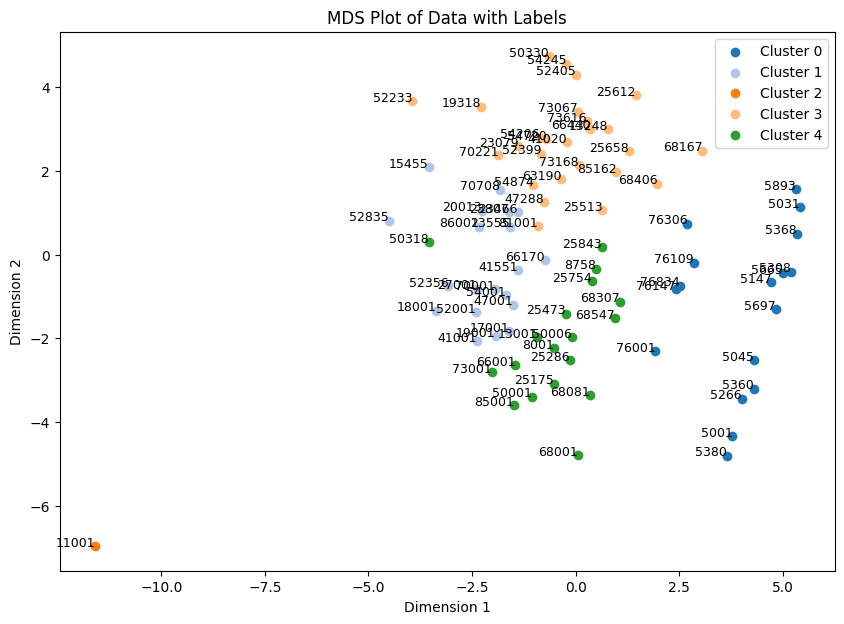

In [105]:
crear_grafico_dispersion(kmeans_1, df_X, df_y)

In [106]:
print("Metrica de silhouette_score: ",silhouette_score(df_X, kmeans_1.labels_))
print("Metrica de Calinski-Harabasz Index: ", calinski_harabasz_score(df_X, kmeans_1.labels_))
print("Metrica de Inercia de k-means: ",kmeans_1.inertia_)

Metrica de silhouette_score:  0.2047473244643959
Metrica de Calinski-Harabasz Index:  27.536537248433415
Metrica de Inercia de k-means:  472.33672974462235


### K-Medoides

In [107]:
Kmedoides_1 = KMedoids(n_clusters = 5, random_state = 42).fit(df_X)

In [108]:
cluster_labels_2= Kmedoides_1.labels_

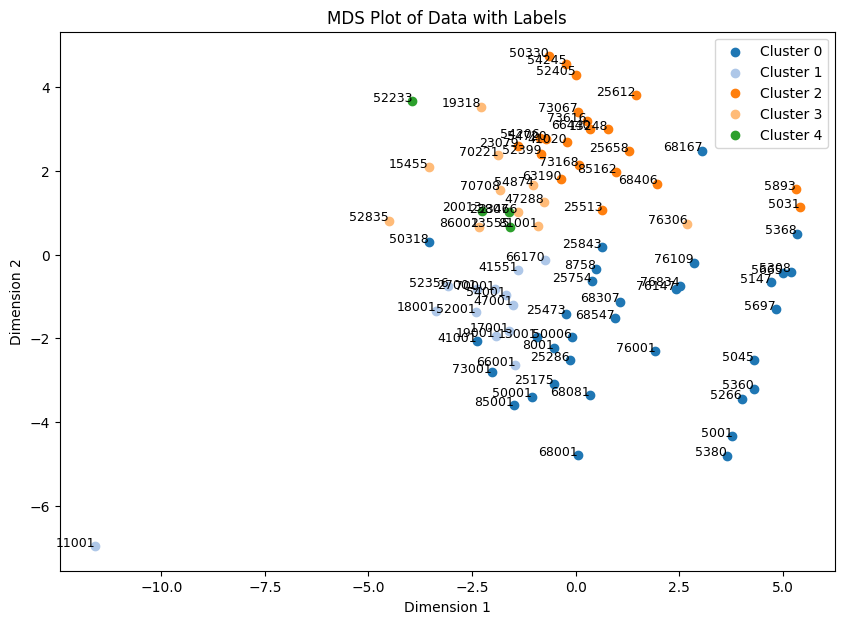

In [109]:
crear_grafico_dispersion(Kmedoides_1, df_X, df_y)

In [110]:
print("Metrica de silhouette_score: ",silhouette_score(df_X, Kmedoides_1.labels_))
print("Metrica de Calinski-Harabasz Index: ", calinski_harabasz_score(df_X, Kmedoides_1.labels_))
print("Metrica de Inercia de k-means: ",Kmedoides_1.inertia_)

Metrica de silhouette_score:  0.06316019606928228
Metrica de Calinski-Harabasz Index:  8.741738393188713
Metrica de Inercia de k-means:  232.94973869825685


## Calibracion parámetros

### K-Means

In [111]:
# Numero de cluster a validar
rg=50

# Inicializar estructuras necesarias para la seleccion de cluster optimo
varianza_intra_cluster = []
silhouettes = []

# iterar entre todos los posibles clusters seleccionados para encontrar el optimo
for k in range (1, rg): # Evaluamos entre 1 a rg clusters posibles
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init=50).fit(df_X)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(df_X, kmeans.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)

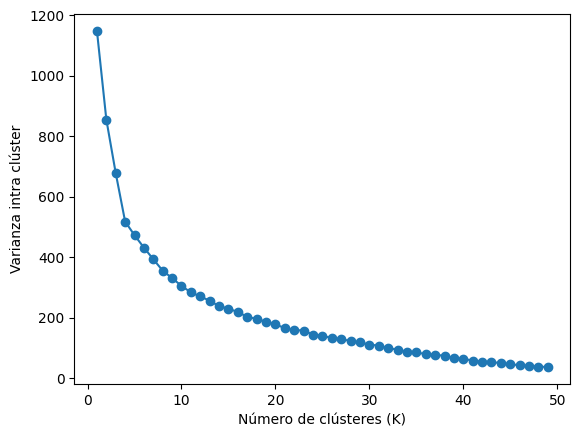

In [112]:
# Graficar la varianza intra cluster por cada uno de las posibles combinaciones de cluster a validar
plt.plot(range(1, rg), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

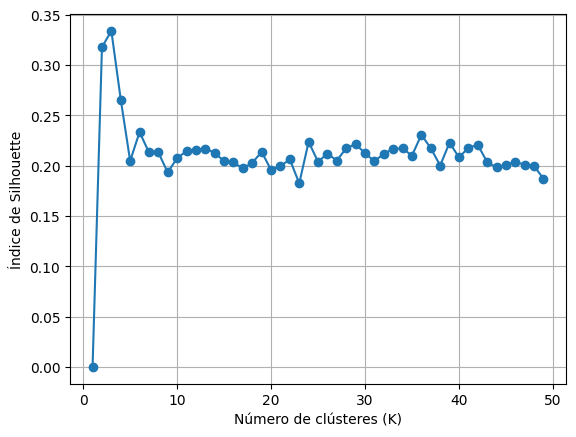

In [113]:
# Graficar el indice de sihoutette por cada uno de las posibles combinaciones de cluster a validar
plt.plot(range(1, rg), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.grid()
plt.show()

### K-Medoides

In [114]:
# Numero de cluster a validar
rg=50

# Inicializar estructuras necesarias para la seleccion de cluster optimo
varianza_intra_cluster = []
silhouettes = []

# iterar entre todos los posibles clusters seleccionados para encontrar el optimo
for k in range (1, rg): # Evaluamos entre 1 a rg clusters posibles
    kmedoids = KMedoids(n_clusters = k, random_state = 42).fit(df_X)
    varianza_intra_cluster.append(kmedoids.inertia_)
    try:
        silhouette = silhouette_score(df_X, kmedoids.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)

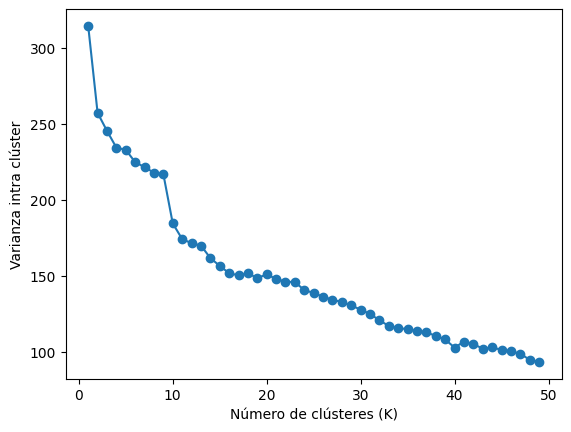

In [115]:
# Graficar la varianza intra cluster por cada uno de las posibles combinaciones de cluster a validar
plt.plot(range(1, rg), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

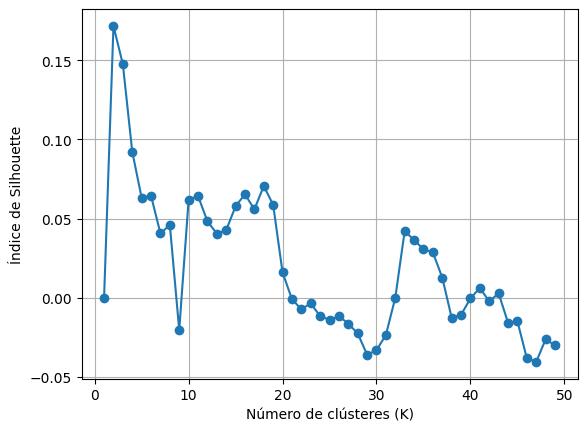

In [116]:
# Graficar el indice de sihoutette por cada uno de las posibles combinaciones de cluster a validar
plt.plot(range(1, rg), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.grid()
plt.show()

## Mejor modelo

In [117]:
kmeans_2 = KMeans(n_clusters = 6, random_state = 42, n_init=50).fit(df_X)

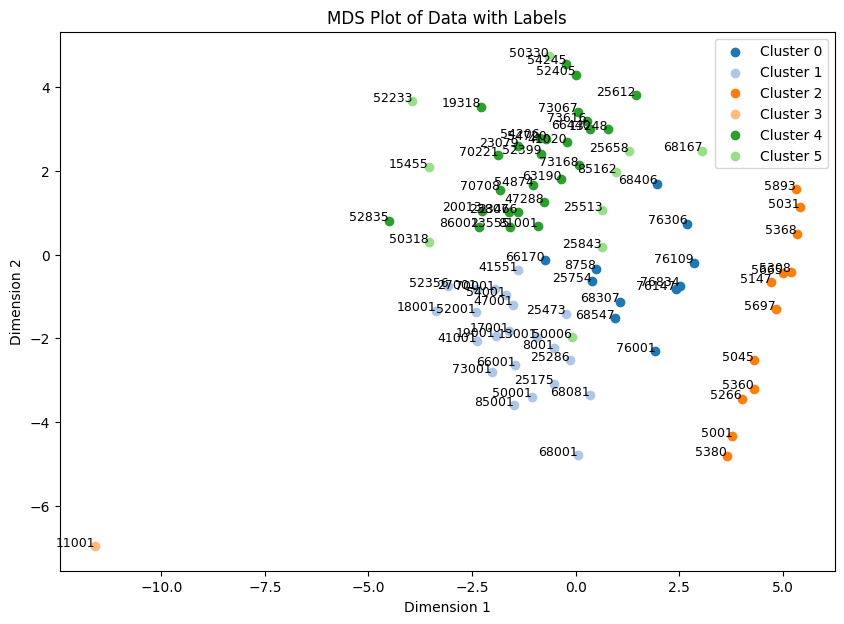

In [118]:
crear_grafico_dispersion(kmeans_2, df_X, df_y)

In [119]:
print("Metrica de silhouette_score: ",silhouette_score(df_X, kmeans_2.labels_))
print("Metrica de Calinski-Harabasz Index: ", calinski_harabasz_score(df_X, kmeans_2.labels_))
print("Metrica de Inercia de k-means: ",kmeans_2.inertia_)

Metrica de silhouette_score:  0.23329078575183598
Metrica de Calinski-Harabasz Index:  25.25946443319756
Metrica de Inercia de k-means:  431.28598572556376


# Analisis Clusters - Mejor Modelo

## Analisis - clusters a data set original

In [120]:
# Obtener las etiquetas de cluster generadas por KMeans
X_clusters = df7
X_clusters.drop(columns=['PB_DANE', 'CodigoD'], inplace=True)
X_clusters.insert(0, 'clusters', kmeans_2.labels_)

# ver df con labels de clusters
X_clusters.head()

,clusters,INDICADOR,Municipio,Porc_part_Educación,Porc_part_Propósito general,PIB_per_capita,PIB_act_financieras,PIB_act_prof,PIB_info_comunicaciones,Cobertura_edu_total,Cobertura_edu_media,Tasa_repitencia,Inv_Ciencia,Porc_trabajos_formales,CANTIDAD_OPERACIONES,MONTO_OPERACIONES
0,2,0.31,MEDELLÍN,0.61,0.08,33738352.00,10206.18,20048.27,5531.18,97.06,56.18,6.41,0.05,0.62,35020083,2969120450068
1,2,0.29,AMALFI,0.04,0.22,33738352.00,10206.18,20048.27,5531.18,71.63,28.92,7.48,0.05,0.12,1836,128857908
2,2,0.17,APARTADÓ,0.60,0.06,33738352.00,10206.18,20048.27,5531.18,94.91,57.86,5.56,0.05,0.29,5145,1324013986
3,2,0.22,CAREPA,0.07,0.17,33738352.00,10206.18,20048.27,5531.18,94.16,45.83,7.48,0.05,0.11,665,45517947
4,2,0.44,ENVIGADO,0.58,0.18,33738352.00,10206.18,20048.27,5531.18,100.44,65.36,6.49,0.05,0.26,1535208,936636951771


In [121]:
# Revisar los municipios con mayor indice en que grupo quedaron
X_clusters.sort_values(by='INDICADOR', ascending=False).head(20)

,clusters,INDICADOR,Municipio,Porc_part_Educación,Porc_part_Propósito general,PIB_per_capita,PIB_act_financieras,PIB_act_prof,PIB_info_comunicaciones,Cobertura_edu_total,Cobertura_edu_media,Tasa_repitencia,Inv_Ciencia,Porc_trabajos_formales,CANTIDAD_OPERACIONES,MONTO_OPERACIONES
19,1,0.52,FLORENCIA,0.57,0.06,14536951.00,144.57,175.48,95.23,93.52,41.47,8.16,0.00,0.22,40513,4272957840
69,1,0.49,IBAGUÉ,0.63,0.06,24308336.00,780.06,1510.89,745.50,109.16,58.41,5.41,0.00,0.34,865254,87423222936
41,1,0.48,VILLAVICENCIO,0.59,0.06,47525776.00,699.25,1159.26,470.61,92.60,52.31,7.49,0.00,0.37,104323,24655560023
6,2,0.46,ITAGÜÍ,0.62,0.10,33738352.00,10206.18,20048.27,5531.18,92.28,59.78,4.08,0.05,0.24,901470,115503475990
4,2,0.44,ENVIGADO,0.58,0.18,33738352.00,10206.18,20048.27,5531.18,100.44,65.36,6.49,0.05,0.26,1535208,936636951771
27,1,0.44,CHÍA,0.64,0.13,28847164.00,1079.33,5196.12,1963.51,109.32,63.87,9.05,0.01,0.30,277114,77233801221
44,5,0.44,MESETAS,0.02,0.50,47525776.00,699.25,1159.26,470.61,81.94,29.76,8.28,0.00,0.03,1415,179984491
14,3,0.43,"BOGOTÁ, D.C.",0.61,0.09,0.00,0.00,0.00,0.00,93.37,62.05,5.72,0.00,0.49,326744528,90121021967085
28,1,0.43,FUNZA,0.64,0.12,28847164.00,1079.33,5196.12,1963.51,99.98,66.70,6.65,0.01,0.26,1728238,166414574869
34,5,0.43,VILLA DE SAN DIEGO DE UBATÉ,0.06,0.28,28847164.00,1079.33,5196.12,1963.51,99.14,59.95,5.19,0.01,0.24,9450,710226910


In [122]:
# describe de los grupos
X_clusters.groupby('clusters').describe()

INDICADOR                                    Porc_part_Educación  \
             count mean  std  min  25%  50%  75%  max               count   
clusters                                                                    
0            11.00 0.19 0.11 0.02 0.14 0.18 0.26 0.39               11.00   
1            22.00 0.28 0.12 0.08 0.20 0.25 0.38 0.52               22.00   
2            12.00 0.22 0.13 0.03 0.13 0.20 0.30 0.46               12.00   
3             1.00 0.43  NaN 0.43 0.43 0.43 0.43 0.43                1.00   
4            26.00 0.21 0.08 0.09 0.16 0.20 0.26 0.39               26.00   
5            10.00 0.33 0.11 0.07 0.31 0.34 0.40 0.44               10.00   

                                            Porc_part_Propósito general       \
         mean  std  min  25%  50%  75%  max                       count mean   
clusters                                                                       
0        0.47 0.22 0.04 0.51 0.54 0.60 0.67                       11.00 0.11   
1        0.59 0.04 0.49 0.57 0.59 0.62 0.65                       22.00 0.07   
2        0.28 0.28 0.03 0.05 0.06 0.59 0.62                       12.00 0.21   
3        0.61  NaN 0.61 0.61 0.61 0.61 0.61                        1.00 0.09   
4        0.06 0.10 0.02 0.04 0.05 0.06 0.53                       26.00 0.28   
5        0.04 0.01 0.02 0.03 0.04 0.04 0.06                       10.00 0.37   

                                       PIB_per_capita                          \
          std  min  25%  50%  75%  max          count        mean         std   
clusters                                                                        
0        0.08 0.04 0.07 0.08 0.09 0.30          11.00 33989510.55  6326695.69   
1        0.03 0.05 0.05 0.06 0.07 0.13          22.00 25122173.27 11354999.20   
2        0.11 0.06 0.14 0.20 0.28 0.40          12.00 33738352.00        0.00   
3         NaN 0.09 0.09 0.09 0.09 0.09           1.00        0.00         NaN   
4        0.15 0.06 0.15 0.25 0.39 0.52          26.00 18563025.88  5489459.22   
5        0.11 0.16 0.30 0.38 0.46 0.51          10.00 36606317.60 11804402.37   

                                                                      \
                 min         25%         50%         75%         max   
clusters                                                               
0        25039898.00 30861469.00 32875774.00 37884455.00 42893136.00   
1        11420489.00 14602009.25 24625676.00 28847164.00 48146500.00   
2        33738352.00 33738352.00 33738352.00 33738352.00 33738352.00   
3               0.00        0.00        0.00        0.00        0.00   
4        12642903.00 14614790.00 14714945.00 24214368.00 28847164.00   
5        13726930.00 28847164.00 37535463.00 47525776.00 48146500.00   

         PIB_act_financieras                                              \
                       count     mean     std      min      25%      50%   
clusters                                                                   
0                      11.00  3265.94 1771.59   772.05  2097.12  2565.84   
1                      22.00   854.43  643.14   103.52   505.86   662.21   
2                      12.00 10206.18    0.00 10206.18 10206.18 10206.18   
3                       1.00     0.00     NaN     0.00     0.00     0.00   
4                      26.00   569.90  246.64    90.23   452.27   602.01   
5                      10.00   899.17  492.77   265.52   693.32   699.25   

                           PIB_act_prof                                     \
              75%      max        count     mean     std      min      25%   
clusters                                                                     
0         5043.35  5043.35        11.00  8342.76 4987.54  1955.68  4128.15   
1         1079.33  2565.84        22.00  2104.95 1866.00     5.87   695.91   
2        10206.18 10206.18        12.00 20048.27    0.00 20048.27 20048.27   
3            0.00     0.00         1.00     0.00     NaN     0

## Conclusion - Clusters

Se identifican 6 clusters de los cuales se resaltan el cluster 3 con un solo municipio el cual es el distrito capital Bogota el cual no sera tomando en cuenta ya que su desarrollo y la inclusion digital que este presenta tiene varios factores especiales con respecto a los demas.

El cluster 5 conformado por 10 municipios los cuales presentan un indicador promedio de 0.33 y un particular porcentaje de participacion en educacion muy bajo siendo de 0.04 en promedio.

y por ultimo el cluster 1 con 22 municipios el cual presenta un indicador promedio de 0.28 y un porcentaje de participacion de educacion mucho mejor el cual es de 0.59 en promedio.

con estos dos clusters podemos evidenciar las 2 situaciones contrarias en el pais donde el indicador ya se encuentra posicionado y con los correctos planes o iniciativas en cada uno podemos mejorar la integracion con las comunidades teniendo en cuenta las necesidades y el contexto donde se encuentran los 2 clusters.

## Exportar DataSet Final

In [123]:
X_clusters.to_csv('DataSetFinalProyectoGradoMIAD.csv', index=False)